<a href="https://colab.research.google.com/github/coreyjadams/AI4NP_School/blob/main/HO_analytic_derivatives.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here we compute the ground-state of the $ndim$-dimensional quantum harmonic oscillator for a system of $npart$ particles. The Hamiltonian of the system reads:

$$ H = -\frac{1}{2m} \sum_{i=1}^{npart} \vec{\nabla}_i^2 + \frac{m \omega^2}{2}\sum_{i=1}^{npart} \vec{x}_i^2 $$

For simplicity, we take $m=1$ and $\omega=1$. According to the variational principle of quantum mechanics, for any trial wave function $|\psi_T\rangle$,

$$ \langle \psi_T | H | \psi_T \rangle ~ \ge ~ E_0 = \frac{1}{2} ndim * npart $$

In this notebook, we assume a trial wave function of the exponential form

$$ \langle x | \psi_T \rangle = \psi_T(x) = \exp \left(-\alpha \sum_{i=1}^{npart} \vec{x}_i^2 \right)$$
where the exact ground state is recovered for $\alpha = 1/2$.

In [ ]:
# Load the libraries that we need for this notebook
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import display, clear_output

In [52]:
class Wavefunction(object):
    """Create a simple wave function in ndim dimensions 
       and for npart particles
       psi(x) = exp(- alpha * sum_i x_i^2)
    """
    def __init__(self, ndim : int, npart : int):
        self.ndim = ndim
        self.npart = npart

    def call(self, alpha, inputs):
        psi = - alpha * np.sum(inputs**2, axis=(1,2))
        return psi

In [53]:
class Hamiltonian(object):
    """Expectation values of the kinetic and potential energies of 
       a collection of independent harmonic oscillators.
    """
    def __init__(self, ndim : int, npart : int, wavefunction : callable):
       self.ndim = ndim
       self.npart = npart
       self.wavefunction = wavefunction

    def potential (self, x):
        """ The HO oscillator potential is given by 
        V = <x|V|psi> / <x|psi> = 1/2 sum_i x_i^2
        """
        pe = 0.5 * np.sum(x**2, axis=(1,2))
        return pe

    def kinetic (self, alpha, x):
        """ For the simple wave function that we consider 
        psi(x) = exp(- alpha * sum_i x_i^2), the kinetic 
        energy can be computed analytically:  
        T = <x|T|psi> / <x|psi> = 1/2 \sum_i (2 alpha - 4 * alpha**2 * x_i^2 )
          = \sum_i (alpha - 2 * alpha**2 * x_i^2 )
        """
        ke = np.sum( alpha * np.ones_like(x) - 2 * alpha**2 * x**2, axis=(1,2))
        return ke

    def energy (self, alpha, inputs):
        """ Sum of the kinetic and the potential energy """
        ke = self.kinetic(alpha, inputs)
        pe = self.potential(inputs)
        en = ke + pe
        return ke, pe, en

In [54]:
class Metropolis(object):
    """Metropolis Sampler in N dimension

    Sample from N-D coordinates, using some initial probability distribution

    """
    def __init__(self,   
          nwalk : int, 
          npart : int,
          ndim : int,
          neq : int, 
          nav : int, 
          nvoid : int, 
          sig : float,
          sig_i : float,
          wavefunction : callable):

          self.nwalk = nwalk 
          self.npart = npart
          self.ndim = ndim
          self.neq = neq
          self.nav = nav
          self.nvoid = nvoid
          self.sig = sig
          self.sig_i = sig_i
          self.wavefunction = wavefunction

# Function that performs nvoid Metropolis steps
    def step(self, alpha, x_o):
        for i in range(self.nvoid):
            log_wpsi_o = self.wavefunction.call(alpha, x_o)
            x_n = x_o + self.sig * np.random.normal(size=[self.nwalk, self.npart, self.ndim])
            log_wpsi_n = self.wavefunction.call(alpha, x_n)
            prob = np.exp( 2 * ( log_wpsi_n - log_wpsi_o ) )
            accept = np.greater(prob, np.random.uniform(size=[self.nwalk]))
            x_o = np.where(accept.reshape([self.nwalk,1,1]), x_n, x_o)
            acc_o = accept.astype('float64')
        return x_o, acc_o

# Function that perform the full Metropolis walk and returns the path and the acceptance
    def walk(self, alpha):
        x_o = self.sig_i * np.random.normal(size=[self.nwalk, self.npart, self.ndim])
        for i in range (neq): 
            x_o, acc_o = self.step(alpha, x_o)
        x_s = []
        acc_s = []
        for i in range (self.nav): 
            x_o, acc_o = self.step(alpha, x_o)
            x_s.append(x_o)
            acc_s.append(acc_o)
        x_s = np.concatenate(x_s)
        acc_s = np.concatenate(acc_s)
        return x_s, acc_s 

In [56]:
# Define the function that computes the average and the standard deviation of each observables
def estimator(observable):
    average = np.mean(observable)
    average_2 = np.mean(observable**2)
    error = np.sqrt(average_2 - average**2) / np.sqrt(observable.shape[0]-1) 
    return average, error

In [57]:
# Set the parameters and instanciate the Wavefunction, Hamiltonian, and Metropolis classes 
sig_i = 1.0         # Gaussian width for sampling the initial configuration 
sig = 0.2           # Gaussian width for sampling the Metropolis Move
neq = 20            # Equilibration steps
nav = 2             # Averaging steps
nvoid = 200         # Void steps between energy calculations
nwalk = 100         # Quantum Monte Carlo configurations
ndim = 3            # Spatial dimension  
npart = 2           # Number of particles
seed = 19.          # Seed to initialize the random-number generator
alpha = 0.6         # Gaussian width of the HO wave function 

wavefunction = Wavefunction(ndim, npart)
hamiltonian = Hamiltonian(ndim, npart, wavefunction)
metropolis = Metropolis(nwalk, npart, ndim, neq, nav, nvoid, sig, sig_i, wavefunction)

In [58]:
# Compute the expectation values by doing a Metropolis walk 
x_s, acc_s = metropolis.walk(alpha)
ke, pe, en =  hamiltonian.energy(alpha, x_s)

energy_average, energy_error = estimator(en)
kinetic_average, kinetic_error = estimator(ke)
potential_average, potential_error = estimator(pe)
print("energy=", energy_average, "+-", energy_error)
print("kinetic energy=", kinetic_average, "+-", kinetic_error)
print("potential energy=", potential_average, "+-", potential_error)

energy= 3.057361802250081 +- 0.020335564830849362
kinetic energy= 1.824093171000264 +- 0.0665527576282346
potential energy= 1.233268631249817 +- 0.046217192797385134


In [ ]:
class Optimizer(object):
    """Class that computes the energy derivative 
    f_i = 2[< E_L O_i > - 2 < E_L > < O_i >]
    and updates the parameters according to the SGD algorithm
    """
    def __init__(self, ndim : int, npart : int, wavefunction : callable):
       self.ndim = ndim
       self.npart = npart
       self.wavefunction = wavefunction

# Computes the derivative of the wave function O_i
    def jacobian (self, x):
        jac = - np.sum(x**2, axis=(1,2))
        return jac

# Computes the gradient of the energy f_i = 2[ < E_L O_i > - 2 < E_L > < O_i > ]
    def gradient (self, x, en):
        jac = self.jacobian(x)
        grad_energy = 2 * (np.mean(en * jac) - np.mean(en) * np.mean(jac))
        return grad_energy

In [ ]:
# Compute the expectation values and the derivative of the energy 
alpha = 0.5
optimizer = Optimizer(ndim, npart, wavefunction) 
x_s, acc_s = metropolis.walk(alpha)
ke, pe, en =  hamiltonian.energy(alpha, x_s)

energy_average, energy_error = estimator(en)
kinetic_average, kinetic_error = estimator(ke)
potential_average, potential_error = estimator(pe)
energy_gradient = optimizer.gradient(x_s, en)
print("energy=", energy_average, "+-", energy_error)
print("kinetic energy=", kinetic_average, "+-", kinetic_error)
print("potential energy=", potential_average, "+-", potential_error)
print("energy gradient=", energy_gradient)

energy= 3.0 +- 0.0
kinetic energy= 1.461075874221766 +- 0.06609480916399997
potential energy= 1.538924125778234 +- 0.06609480916399997
energy gradient= 3.552713678800501e-15


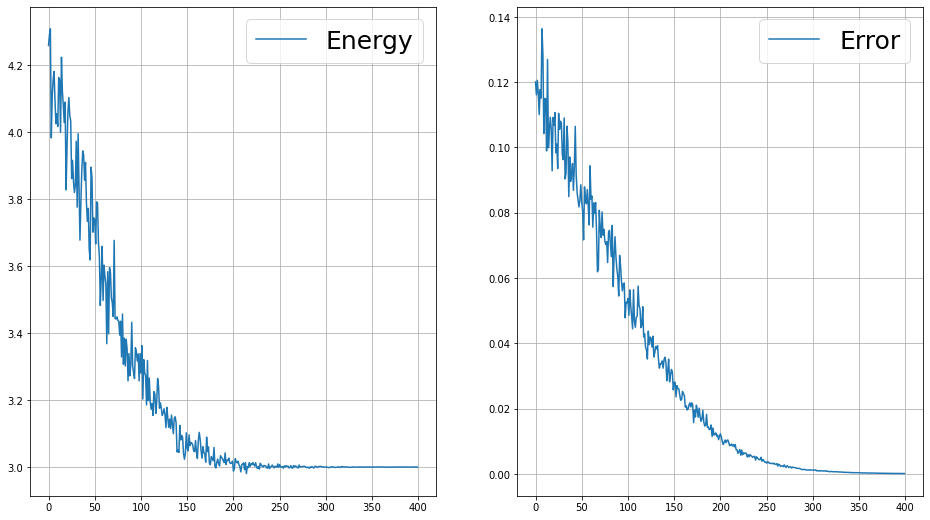

In [48]:
# Optimize with the simple SGD algorithm 
alpha = 1.2
LR = 0.002

# Define a figure here which we can update along the way:
fig       = plt.figure(figsize=(16,9))
# Create 2x2 sub plots

gs = gridspec.GridSpec(2, 2)
ax_loss   = plt.subplot(gs[:,0])
ax_err    = plt.subplot(gs[:,1])

steps_history = []
energy_history  = []
error_history = []
for i in range (400):
    x_s, acc_s = metropolis.walk(alpha)
    ke, pe, en =  hamiltonian.energy(alpha, x_s) 
    energy_average, energy_error = estimator(en)
    energy_gradient = optimizer.gradient(x_s, en)
    alpha = alpha - LR * energy_gradient

    steps_history.append(i)
    energy_history.append(energy_average)
    error_history.append(energy_error)

    # Here we update the plots.  Show the energy function:
    ax_loss.set_xlim(0, 1.1*i)
    ax_loss.cla()
    ax_loss.plot(steps_history, energy_history, label="Energy")
    ax_loss.grid(True)
    ax_loss.legend(fontsize=25)

    # Show the error function:
    ax_err.set_xlim(0, 1.1*i)
    ax_err.cla()
    ax_err.plot(steps_history, error_history, label="Error")
    ax_err.grid(True)
    ax_err.legend(fontsize=25)

    display(fig)
    clear_output(wait = True)
    plt.pause(0.25)
    


